In [340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
import seaborn as sns

In [341]:
df = pd.DataFrame([]) # defining a dataframe
df = pd.read_csv('../Data/Cleaned/data.csv')

df['Code'] = df['Code'].astype('category')
df.head()

df['Date_Time'] = pd.to_datetime(df['Date_Time'].str.strip(), 
                                 format="%Y-%m-%d %H:%M:%S", errors="raise")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28253 entries, 0 to 28252
Data columns (total 5 columns):
Code                28253 non-null category
Blood_Glucose       28253 non-null float64
Patient_ID          28253 non-null int64
Code_Description    28253 non-null object
Date_Time           28253 non-null datetime64[ns]
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 911.4+ KB


In [342]:
df.head()

,Code,Blood_Glucose,Patient_ID,Code_Description,Date_Time
0,58,101.0,31,PRE_BREAKFAST,1991-05-20 08:00:00
1,33,5.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00
2,34,27.0,31,NPH_INSULIN_DOSE,1991-05-20 08:00:00
3,60,89.0,31,PRE_LUNCH,1991-05-20 12:00:00
4,33,3.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00


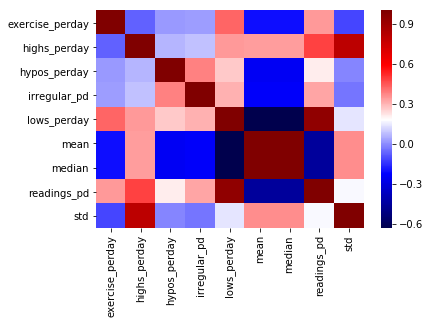

In [374]:
group_df = df.groupby('Patient_ID')

df_agg = pd.DataFrame({
    'mean' : group_df['Blood_Glucose'].mean(),
    'median' : group_df['Blood_Glucose'].mean(),
    'std' : group_df['Blood_Glucose'].std(),
    'highs_perday' : group_df.apply(lambda group : group[group['Blood_Glucose']>200]['Blood_Glucose'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'lows_perday' : group_df.apply(lambda group : group[group['Blood_Glucose']<70]['Blood_Glucose'].count()
                                   /(group.Date_Time.max() - group.Date_Time.min()).days),
    'hypos_perday' : group_df.apply(
        lambda group : group[group['Code_Description']=='HYPOGLYCEMIC_SYMPTOMS']['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'exercise_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='TYPICAL_EXERCISE')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'irregular_pd' : group_df.apply(
        lambda group : group[(group['Code_Description']=='LESS_EXERCISE') |
                            (group['Code_Description']=='MORE_EXERCISE') |
                            (group['Code_Description']=='MORE_MEAL_INJESTION') |
                            (group['Code_Description']=='LESS_MEAL_INJESTION')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'readings_pd' : group_df['Date_Time'].apply(lambda group : group.count()
                                                /((group.max() - group.min()).days))
})


corr = df_agg.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap='seismic')
plt.show()

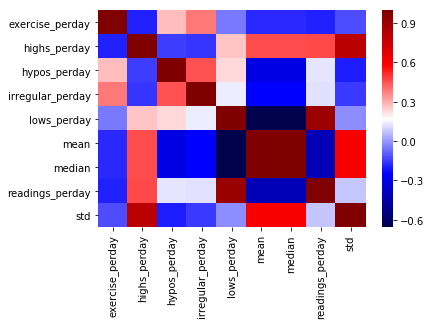

In [400]:
corr = df_agg[df_agg.loc[:,'hypos_perday']>0.0].corr()

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap='seismic')
plt.show()

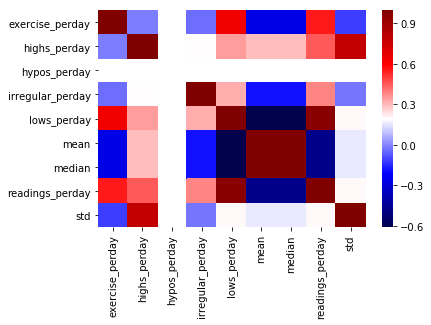

In [401]:
corr = df_agg[df_agg.loc[:,'hypos_perday']==0.0].corr()

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap='seismic')
plt.show()